In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import decision_trees_helper as dthelp
%aimport decision_trees_helper

import os 

TITANIC_PATH = os.path.join("./external/jack-dies", "data")

train_data_titanic = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data_titanic  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )

from IPython.display import Image


# Plan

In this lecture we review several Classical Machine Learning models.

These also allow us to introduce some concepts that are useful for many other models.

- Decision Trees
    - Simple Trees
    - Random Forests
        - introduce 
            - Ensembles
            - Bootstrapping, Bagging
- Boosting
- Support Vector Machines
    - Margin Loss

# Decision Trees

Our prior models for the Classification Task (and the Support Vector Machine model)
have a true mathematical basis.

In contrast, Decision Trees have a more "operational" description and may feel less like
Classical Models.

As usual we let $C$ denote the set of distinct classes (possible targets) for our Classification task.

## Trees: terminology
- A tree consists of
    - *nodes*
        - a node is a branching point
    - *edges*
        - an edge is a directed arrow from a node to another node
        - edge goes from *parent* node to *child* node
        - edges are acyclic
    - *path*
        - a sequence of edges from the root to a node
    - *root node* is the single node in the tree with **no** branches entering
    - *leaf nodes*
        - a node with no edge leaving

A **Decision Tree**
- Nodes are labelled with questions
- Edges are labelled with answers
    - so a path from the root to a node is a *sequence of question/answers*
    
Each node corresponds to a subset of the Training examples
- the root nodes corresponds to the entire Training set examples
- the children of a node correspond to disjoint subsets of a node's examples
    - the answer to the question creates a subset defined by the answer

So a path from the root to a node
- is a sequence of question/answers
- the conjunction of the question/answers is a condition that defines a partition

Leaf nodes are *terminal* partitions (not sub-divided)

We can associate a classification with each node
- a function that maps the examples in a node to a class
- the final prediction is associated with the classification of a leaf node

We illustrate these terms via a Decision Tree for the Titanic classification problem.

- root
- node
    - question
- leaf
- edge
    - answer
- path
    - sequence of question/answers

An explanation of the details of a node label will come in a moment.

SexToInt:transform: Cheating alert!, X has 2 columns.


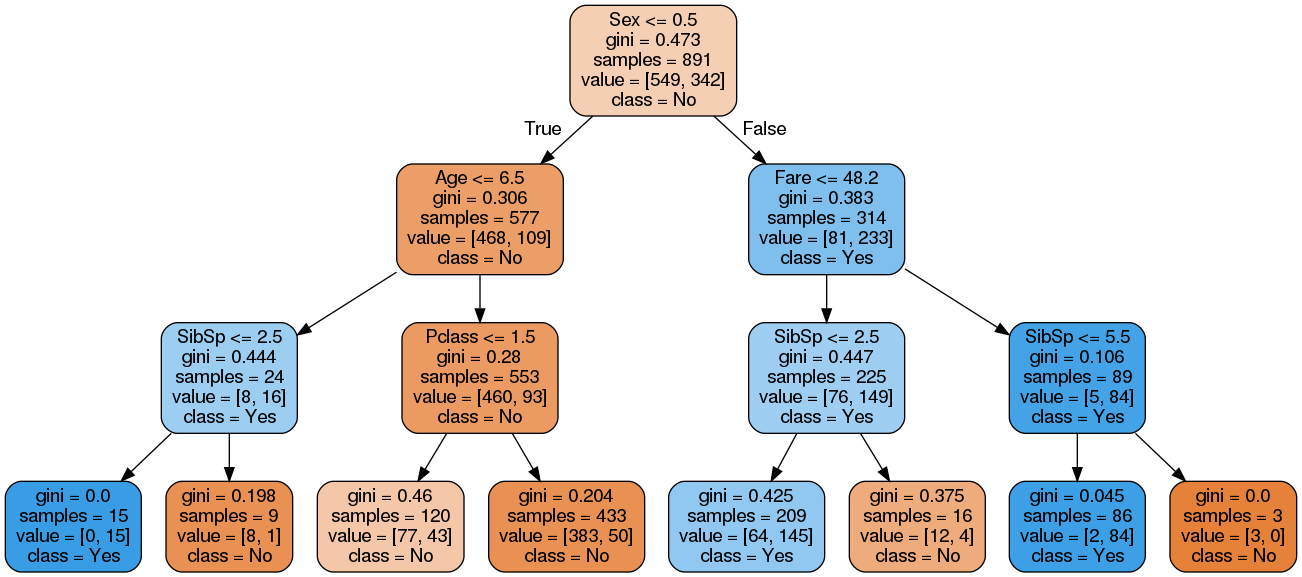

In [4]:
th = dthelp.TitanicHelper()
png = th.make_titanic_png(max_depth=3)
Image(filename=png + ".png") 

## High Level view
 
 ### Prediction
Before we explain how to construct a Decision Tree, let's explain how we predict.

Given a test example (with features $\x$)
- apply the sequence of questions to $\x$
- this defines a path to a leaf node
- prediction $\hat{y}$ is the prediction of the leaf

This makes prediction in Decision Trees very fast.

### Construction
A Decision Tree is constructed
- For each node (partition)
    - Decide the question used to create sub-partitions
- Continue asking questions (sub-partitioning the Training set)
    - until a Stopping Condition is met


## Medium level view

Let's examine the detailed contents of the node labels.

This will serve as background for the detailed construction of a Decision Tree.

Again we use the Titanic, although a smaller tree so we can read the details.

- **Note**
- The first 2 levels of the smaller (depth 2) and larger (depth 3) trees are the same.
- But the leaves are different
    - Leads to different predictions

In [5]:
th = dthelp.TitanicHelper()
th.make_titanic_png()

SexToInt:transform: Cheating alert!, X has 2 columns.


'images/titanic_2level'

![](images/titanic_2level.png)

- Root
    - Full set of 891 training examples
    - `Survive = No` for 549; `Survive == Yes` for 342
    - `No` is most frequent value, so prediction (`Class`) for root is `No` (orange)

- First question (root)
    - Is `Sex == Male (0)` ?
        - n.b., this is our somewhat wrong initial model (e.g., Sex is binary numeric)

- Partitions the 891 examples at root into
    - Left sub-tree (Male)
        - 577 training examples
        - `Survive = No` for 468; `Survive = Yes` for 109
        - `No` is most frequent value, so prediction (`Class`) for left subtree is `No`
    - Right sub-tree (Female)
        - 314 training examples (891 from parent, less 577 from sibling)
        - `Survive = No` for 81; `Survive = Yes` for 233    
        - `Yes` is most frequent value, so prediction (`Class`) for right subtree is `Yes`

- leaves
    - left blue
        - only 24 Males children <= 6.5, two thirds survived
        - Males older than 6.5: most died
    - right blue
        - Female, hi fare almost certainly survived 1:17, high purity (low gini)
  
So each question along path partitions the parent subset into complementary subsets

## How do we construct the Decision Tree

There are several variations of Decision Tree algorithms.

The one we describe treats each feature $\x_j$ as coming from a discrete set of values $V_j$:
- Categorical $\x_j$: 
    - $V_j = C_j$, where $C_j$ are the distinct classes for feature $j$
- Continous $\x_j$:
    -  $V_j = \{ \x^\ip_j | 1 \le i \le m \}$
    - the set of distinct values of $\x_j$ in the training examples
    - this is equivalent to One Hot Encoding $\x_j$ into a vector of length $| V_j |$
        - $\text{Is}_{\x_j = v} $ for $v \in V_j$

Our splits (questions) will be binary, with Yes/No answers.

There are variants with greater cardinality of splitting.

### Questions

The question at node $\node{n}$ splits $S_n$ into 2 disjoint subsets
$$
\begin{array}[llll]\\
S_n & = & L_n \cup R_n \\
 \phi& = & L_n  \cap R_n \\
 L_n & = & \{ (\x^\ip, \y^\ip) | (\x^\ip, y^\ip) \in S_n, \; \text{"True" answer to question} \} \\
 R_n & = & \{ (\x^\ip, \y^\ip) | (\x^\ip, y^\ip) \in S_n, \; \text{"False" answer to question} \} \\
\end{array}
$$

That is, the question  partitions $S_n$ into  "left" and right subsets $L_n, R_n$ depending on the answer.

A question consists of a feature $\x_j$ and a comparator (threshhold) $t_{n,j} \in V_j$
- Represent question as a pair: $(j, t_{n,j})$
- Compares $x_j$ and $t_{n,j}$ 
    - Categorical $\x_j$: Is $\x_j = t_{n,j}$?
    - Continuous $\x_j$: Is $\x_j \le t_{n,j}$?
    
Deciding the $j$ and $t_{n,j}$ at a node $n$ will be at the heart of the algorithm.

### Algorithm: High level

[sklearn manual](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation)

- Initialization:
    - create a Root node corresponding to the all the training examples
        - $S_\text{root} = \{ (x^\ip, y^ip) | 1 \le i \le m \}$

The algorithm will *recursively* split the training examples at node $\node{n}$

`split`$(\node{n}, S_n)$: create left/right subtrees $L_n, R_n$ as children of $\node{n}$ as follows:
   - if we can split $\node{n}$
       - Determine the question that "best" splits $S_n$ into $L_n, R_n$
       - Create a child node $\node{n}_L$ with corresponding examples $L_n$
       - Create a child node $\node{n}_R$ with corresponding examples $R_n$
       - `split`$(\node{n}_L, L_n)$
       - `split`$(\node{n}_R, R_n)$


### Prediction $\hat{\y}_n$ for node $\node{n}$

Let's count the number of examples in $S_n$ for each class $c \in C$
$$
\cnt{n,c} = | \{ i | (\x^\ip, \y^\ip) \in S_n, \y^\ip = c\} |
$$

Then our prediction for a node $\node{n}$ (not just leaf nodes) is the class $c$ with the greatest count.

$$
\hat{\y}_n = \argmax{c \in C}{ \cnt{n,c} }
$$

The high level description was vague on
- how do we define the "best" split of the examples at node $\node{n}$ ?
- what does "if we can split"a node mean ?

We answer each in turn.

### Measuring the quality of a split

In order to determine the "best" split, we need a metric of the quality of the split.

We start with measuring the "randomness" of a node $\node{n}$
- The examples $S_n$ may correspond to different classes, each with
its own frequency.

- So $S_n$ induces a probability distribution on the class labels.

- We need a metric that measures the randomness of this distribution at node $\node{n}$

If we had a metric of randomness, we can define
our quality metric of a split as the difference between
- the randomness of $S_n$
- the weighted (by size) randomness of nodes $L_n, R_n$

We call this metric the *information gain* achieved by the split.

The *best split* would be the one which maximizes the information gain.

Any ideas for a metric of randomness of a distribution ?

Entropy !

This a a very good measure to use.

In the interest of showing alternatives,
we continue with a different choice.

Gini.


### Gini score

For node $\node{n}$:
- Let $p_{n,c}$ be the fraction of $S_n$ examples with class $c \in C$
$$
p_{n,c} = \frac{\cnt{n,c}}{|S_n|}
$$
    
Then the Gini score (metric of randomness) of node $\node{n}$ is defined as
$$
G_n = 1 - \sum\limits_{c \in C} {{p_{n,c}}^2}
$$

$G_n$ is called the **impurity** of node $\node{n}$

**Note** so we will try to minimize *impurity* (just as we would minimize entropy)

Goal is to have pure nodes, i.e., all observations in node $\node{n}$ are in same target class.

Here's what Gini looks like as a function of $p_{n,c}$ for binary $C$

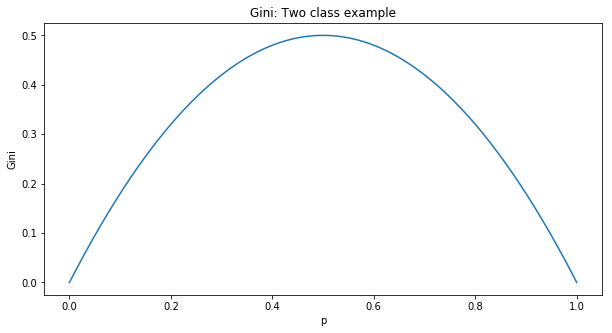

In [6]:
gh = dthelp.GiniHelper()
_ =gh.plot_Gini()

Just like Entropy, Gini impurity
- is minimized by a pure distribution (of either class)
- is maximized by an equally balanced distribution

#### Gini illustration

It will be easiest to illustrate with a toy example having only categorical features.

In [7]:
gh = dthelp.GiniHelper()
_ = gh.make_logicTree_png()

Here are the observations

In [8]:
df_lt = gh.df_lt
df_lt

,feat 1,feat 2,feat 3,target
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,0
7,1,1,1,1


![](images/logic_tree.png)

Let's compute Gini of the root

In [9]:
gini_lt = gh.gini(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

print("\n\nMethod returns ", gini_lt)

Gini, by hand:
Count by target:
	
0    5
1    3
Name: target, dtype: int64
Frequency by target:
	
0    0.625
1    0.375
Name: target, dtype: float64

1 - sum(freq**2) = 0.469


Method returns  0.46875


And Gini of the right sub-tree

In [10]:
df_right = df_lt[ df_lt["feat 3"] > 0.5 ]

gh.gini( df_right, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Gini, by hand:
Count by target:
	
1    3
0    1
Name: target, dtype: int64
Frequency by target:
	
1    0.75
0    0.25
Name: target, dtype: float64

1 - sum(freq**2) = 0.375


0.375

#### The "best" ($j,k)$ split: From Gini of children, to Cost for split at parent

Let node $\node{n}$ 
- have child nodes $n_L, n_R$
- $S_n$ denote the set of examples corresponding to node $\node{n}$
- have Gini impurity score $G_n$

We can associate a Cost with the choice of splitting node $\node{n}$ with question $(j, t_{n,j}$):
$$
\text{Cost}_{j,t_{n,j}}(S_n) = \frac{m_L}{(m_L + m_R)} G_L + \frac{m_R}{(n_L + m_R)} G_R
$$

- where $m_L =| S_{n_L} |, m_R = | S_{n_R} |$

That is, the Cost of splitting $S_n$ on $X_j \le t_{n,j}$ is 
- the weighted sum of the Gini's of the partitions created.

Finally:
- the best split $(j, t_{n,j})$ for node $\node{n}$ is the one that minimizes the Cost

$$ j, t_{n,j} = \argmin{j,t_{n,j}} { \text{Cost}_{j,t_{n,j}} }$$
- $1 \le j \le n$
- $t_{n,j} \in V_j$

This is the split that maximizes Information Gain (since $G_n$ is constant, relative to the choices)

Let's examine the cost of split at the root for each (binary) feature

In [11]:
gh.cost(df_lt, gh.target_name_lt, gh.feature_names_lt, noisy=True)

Split feature feat 1 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 2 on 0.00
	G_left (# = 4) = 0.375, G_right (# = 4) = 0.500
	weighted (G_left, G_right) = 0.438
Split feature feat 3 on 0.00
	G_left (# = 4) = 0.000, G_right (# = 4) = 0.375
	weighted (G_left, G_right) = 0.188


0.1875

So split on $(3, 0)$ (feature "feat 3", threshold 0) gives the minimum cost.

That explains the split at the root.

### What does "if we can split"a node mean

Time to answer our second vague statement: is there a time when we can't/shouldn't split node $\node{n}$

**When can't we split** $S_n$ **?**
- $| S_n | = 0$
    - an empty child, which we ignore (n.b., whose sibling is pure)
- $S_n$ is pure

**When shouldn't we split** $S_n$ **?**

One obvious case
- when the Information Gain of **all** possible splits is negative

There are some less obvious cases related to the Performance Measure of our out of sample test set.

If we don't restrict the answer to "if we can split" 
- Then we will eventually have
leaf nodes that are all pure.
- That's good, but it's also possible to have a single example corresponding to a leaf node
- Overfitting !
    - memorize training: each leaf memorizes an example


## Hyper parameters for Decision Trees
### Hyper parameters to control overfitting
You can combat overfitting with several parameters
- `max_depth`: maximum depth of tree
- `min_samples`: minimum size (no. of observations) to split a node
- `min_samples_leaf`: minimum number of samples for a leaf

### Other hyper parameters

Recall that our comparator $t_{n,j}$ for feature $\x_j$ was drawn from $V_j$
- set of distinct values of $\x_j$ in the training set

This can be quite large.  Perhaps defining a smaller number of threshholds may work even better.
- The choice of threshholds is a hyper paramter

## Advantages and Drawbacks
   
### Advantage
- Interpretable
    - Can explain a prediction with the sequence of question/answers on path to leaf
    - **But** the conjunction of lots of tests is explicit but not always "understandable"
- Very fast inference (test time prediction)
    - just a small number of comparisons

## Decision Tree Regression

**TO DO** Picture
- Very similar to Classification
- Prediction at node $\node{n}$: the average of $y$ that occurs in $S_n$
- use MSE rather than Gini as measure of impurity
             
                    
- Doesn't extrapolate at all: just clips at extreme prediction

### Prediction $\hat{\y}_n$ for node $\node{n}$

$$
\hat{y}_n = \dfrac{1}{m_n}\sum\limits_{\scriptstyle (\x^\ip, \y^\ip) \in S_n}y^{(i)}
$$

### How good is the split $(j,t_{n,j})$ ?: Regression target - MSE

**Equation 6-4: CART cost function for regression**

$
J(j, t_{n,j}) = \dfrac{m_{n_L}}{m}\text{MSE}_{n_L} + \dfrac{m_{n_R}}{m_n}\text{MSE}_{n_R} \quad
\text{where }
\begin{cases}
\text{MSE}_{n} = \sum\limits_{\scriptstyle (\x^\ip, \y^\ip) \in S_n}(\hat{y}_n - y^{(i)})^2\\
\hat{y}_n = \dfrac{1}{m_n}\sum\limits_{\scriptstyle (\x^\ip, \y^\ip) \in S_n}y^{(i)}
\end{cases}
$

### Overfitting example

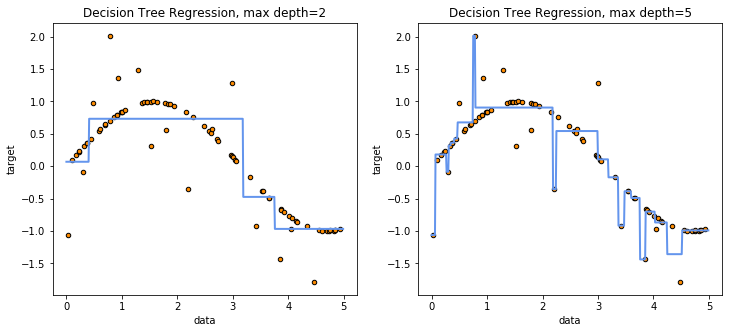

In [12]:
rh = dthelp.RegressionHelper()

_ =rh.make_plot()

![](images/tree_regress_depth_2.png)

## Aside: One-hot encoding for categorical vs. numerical

The discretization of continuous variables is
 a good illustration of the difference between one-hot encoded categoricals and numeric encoded categoricals.

- Consider Titanic Passenger Class `Pclass` $\in \{1,2,3\}$
- As a numeric, `Pclass` implies an ordering (magnitude doesn't matter for Decision Tree split)
- So 
    - numeric `Pclass`: $\lnot (\text{PClass} \le 2)$ are classes $\{ 3 \}$
    - categorical `Pclass`: $\lnot \text{Is}_{Pclass=2}$  are classes$\{ 1, 3 \}$

Not the same !

# Ensembles

Why use a single model when  you can use many ?

Can apply ensemble method to any model, or even a mixture of models

We will illustrate with ensembles of Decision Trees: Random Forest

- Replace **strong learner**: single complex model (e.g., deep tree) 
- with many **weak learners**: simple models (e.g, restricted trees) 
    - restrict in split choice, depth
- Prediction
    - each weak learner predicts; voting on single prediction

<div class="alert alert-block alert-warning">
    <b>Note:</b> 
    <br>
    <ul>
        <li>Ensembles combine multiple weak learners into a strong, single learner.</li>
        <li>The learners are often, but not necessarily, Decision Trees.</li>
</div>

# Random Forests

- Addresses some drawbacks of Decision Trees
- Introduces Ensemble methods
- Combines "weak learners": preview of boosting

## Avoiding a poor training set
- Decision Trees very sensitive to training set
    - what if we were unlucky ?

### Bootstrapping
- Suppose you had a fair coin; it's still possible to get an unlucky sample
- Let's assume training set is a fair representation of the true distribution
    - create new training set of same size
    - random sampling *with replacement*
    -  you wind up with many representative training sets, some lucky, some not

With replacement, approximately 30% of the examples from the original set are *not* in the boostrap
- others appear more than once
- *out of bag*
    - a natural validation example for the Tree(s) created from this bootstrap

## Avoid poor, greedy choices
- At each level of tree
    - limit choice of features on which to split to $k$ random available choices
- That's what makes this a "weak" learner: absence of full choice
    - but may avoid bad greedy choice
- NOTE: there are potentially a lot of choices
    - $V_j$ choices for feature $\x_j$
        - number of categories; number of distinct continuous values in training set

## Bagging

- Bootstrapping with replacement
    - creates a new training set
    - some original training examples are missing
        - **out of bag**
    - results in one model per bootstrapped training dataset

- Aggregate predictions of the model from each boostrapped sample

This process is called **bagging**


## Random Forest Algorithm
- Decide how many $d$ Decision Trees to create
- `for t in range(0,d):`
    - bootstrap a new training set $S_\tp$ from $S$ &nbsp; s.t., $|S_\tp| = |S|$
    - create decision tree $T_\tp = $ `split` $(\text{root}, S_\tp, k)$
        - Training set is $S_\tp$, **not** S
        - at each split, limit set of choices ($j, t_{n,j}$) to size $k$
- Result is a set (**forest**) of $d$ trees: $\{ T_\tp | t = 1, \dots, d \}$

`split`$(\node{n}, S_n, k)$: create left/right subtrees $L_n, R_n$ as children of $\node{n}$ as follows:
   - if we can split $\node{n}$
       - Determine the question that "best" splits $S_n$ into $L_n, R_n$
           - Limit choice to $k$ pairs $(j, t_{n,j})$
       - Create a child node $\node{n}_L$ with corresponding examples $L_n$
       - Create a child node $\node{n}_R$ with corresponding examples $R_n$
       - `split`$(\node{n}_L, L_n, k)$
       - `split`$(\node{n}_R, R_n, k)$


## Prediction in a Forest

There are now $d$ trees, each created independently.

To predict for an example with feature vector $\x$:
- predict for each tree
    - $d$ predictions
- combine the $d$ predicitons into a single prediction
    - majority vote
 

# Boosting

Boosting, like Ensembling, constructs multiple weak learners and combines them into a single strong learner.

But the learners contructed by Ensembling are **independent** of one another.

In contrast, Boosting constructs a **sequence**: 
- the next learner compensates for the weakness of the current learner.

We will illustrate, again, with Decision Trees.

<div class="alert alert-block alert-warning">
    <b>Note:</b>
    <br>
    <ul>
        <li>Ensembling contructs a <i>set</i> of weak, independent learners.
        <li>
            Boosting constructs a <i>sequence</i> of weak learners
                <ul>
                    <li>Each successive learner in the sequence depends on it's predecessors</li>
            </ul>
        </li>
        <li>
    The learners are often, but not necessarily, single level Decision Trees ("stumps")
            </li>
    </div>

Build a *sequence* of Trees to match target $\y$
$$
T_{(0)}, T_{(1)}, \ldots
$$

Each tree incrementally improves (reduces Loss) the prior prediction $\hat{\y}$

**Notation**

Since we are dealing with sequences, we need to identify elements in a sequence
- sequence notation: subscript $\tp$ for element $t$ in the sequence

The most powerful class of Boosting techniques is called Gradient Boosting.

We will start with a special case: AdaBoost.

## AdaBoost

**Key ideas**
- Construct a sequence of trees
- Each tree $T_\tp$ is a stump
- All trees are **not** equally important
    - there are tree weights: $\text{importance}_\tp$
    - consider trees $T_\tp, T_{(t')}$
        - if the performance (accuracy) of $T_\tp$ is higher than that of $T_{(t')}$
            - $\text{importance}_\tp > \text{importance}_{(t')}$
    - final prediction is importance-weighted aggregation of predictions of each tree

**Key ideas (continued)**
- All examples for $T_\tp$ are **not** equally important
    - example $i$ in $T_\tp$ has weight: $\text{say}_\tp^\ip$
    - Overweight (increase $\text{say}_\tp^\ip$) examples that were *misclassified* in $T_{(t-1)}$
    
The basic idea is for tree $T_\tp$ on focus on the errors of $T_{(t-1)}$.

Hence, the trees are not independent.


Construct the sequence:   
- assign equal say to each observation in the training set

- `for i in range(0,W):`:
    - Construct tree $T_\ip$
        - Impurity calculated on a (say) weighted basis
        - $\text{importance}_\ip =  1 -  \text{(sum of says of incorrectly classified examples)}$
        - re-weight observations
            - increase ("boost") say of observations incorrectly classified by $W_i$
            - decrease say of observations correctly classified by $W_\ip$
            - the boost increases with $\text{importance}_\ip$
                - if $T_\ip$ is important (classifies well)
                - then its *misclassified* examples take extra importance in $T_{(i+1)}$
            

# Gradient Boosting

Here are some sequences that we'll encounter
- a sequence of trees $T_\tp$
    - each produces an incrementally better prediction of $\y: \hat{\y}_\tp$
- a sequence of predictions $\hat{\y}_\tp$

Each tree $T_\tp$ is a Regression Tree with its own target $\e_\tp$, so here are some more sequences
- targets: $\e_\tp$
- predictions of targets: $\hat{\e}_\tp$



Here's how we build the sequence of trees 
$$
T_{(0)}, T_{(1)}, \ldots
$$

- **Initialization:** Define tree $T_{(0)}$ to simply predict the mean value of $\y$
    - $\hat{\y}_{(0)} = \bar{\y}$

- **Iterate:** Build Regression Tree $T_\tp$ from predictions of $T_{(t-1)}$
    - Define target $\e_\tp$ to be predicted by  $T_\tp$
        - residual (error wrt $\y$) from prior tree $T_{(t-1)}$: 
            - $\e_\tp = \y - \hat{\y}_{(t-1)}$
    - Build Regression Tree with predictions $\hat{\e}_\tp$
    - Use $\hat{\e}_\tp$ to improve prediction of $\y$:
        - $\hat{\y}_\tp = \hat{\y}_{(t-1)} + \hat{\e}_\tp$

So tree $T_\tp$ improves $\hat{\y}$ from $\hat{\y}_{(t-1)}$ to $\hat{\y}_\tp$

The improvement of $T_\tp$ comes from trying to compensate for the errors $\e_\tp$ of the
previous prediction in the sequence.

Notes on building the tree $T_\tp$
- each tree $T_\tp$ constructed from *scratch*
    - does not "extend" tree $T_{t-1}$
    - but derives its target from the residual of $T_{t-1}$
    - it's possible that the questions/answers of $T_\tp$ and $T_{t-1}$
        - but the two trees have *different* targets, so it's not redundant     
         

There are several keys to this iterative process
- Regression Tree: Information Gain is based on MSE, not Gini or Entropy
    - our goal is low regression error
- we *slowly* improve $\hat{\y}$
    - $\hat{\y}_\tp = \hat{\y}_{(t-1)} + \alpha *\hat{\e}_\tp$
        - *learning rate* $\alpha \le 1$
    - **rather than**
        - $\hat{\y}_\tp = \hat{\y}_{(t-1)} + \hat{\e}_\tp$

Although this process seems very ad hoc, it is in fact performing
- *Gradient Descent* on the MSE Loss !
    - Note: the derivative of the MSE Loss
        - is proportional to sum of residuals
        - as we showed in the Maximum Likelihood lecture

*Gradient Descent* is a search process for optimization that will be the basis for Deep Learning.

We will learn about it in a subsequent lecture.

# Feature Importance

Given the $n$ features in $\x$, which are the "most important" ?

The multiple trees in a Random Forest offer several ways to answer this question.

## Importance: Decrease in Impurity

Recall that the question that splits the examples corresponding to a node is chosen so as
to maximize Information Gain.

One method of measuring the importance of $\x_j$ is the amount of impurity decrease it creates.

- For each feature $x_j$
    - find each node $\node{n}$ in *any* tree in the forest with question $(j, v)$ for *any* $v$
        - compute the information gain of the split on $(j, v)$ 
    - average the information gain across all such nodes
    
That is, how much does impurity decrease when $\x_j$ is used in a question.

- This is a biased method
    - Recall the universe of possible values of $\x_j$ is $V_j$
    - Larger $| V_j |$ means $\x_j$ is more likely to appear in a questions
        - e.g., when $\x_j$ is a continuous variable that has been made discrete
    - So $\x_j$ will appear in more questions


## Importance: Permutation importance

**TO DO** Picture

Let's consider building one tree from bootstrapped sample $S$.

Create another sample $S'$, derived from $S$ by *permuting* the values of $\x_j$.
- maintains the unconditional distribution of $\x_j$
- breaks the correlation of $\x_j$ with the target and other features

We can now measure the importance of $\x_j$ as
- the change in out of bag accuracy of the tree built from $S$ and $S'$.

That is, if $\x_j$ is unimportant, then permuting its values should have little effect on accuracy.

Permutation importance also has issues
- may be biased if $\x_j$ is strongly correlated with another feature $\x_{j'}$

In that case $\x_{j'}$ may compensate for the permuted $\x_j$, making $\x_j$ seem unimportant.

In [13]:
print("Done")

Done
